In [1]:
from flyanalysis import braidz
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

In [2]:
def read_single_file(file_path: str):
    return braidz.read_braidz(file_path)

def get_angular_velocity(df, idx_before, idx_after):
    xvel = df["xvel"].to_numpy()
    yvel = df["yvel"].to_numpy()

    thetas = np.arctan2(yvel, xvel)
    thetas_u = np.unwrap(thetas)
    angular_velocity = np.gradient(thetas_u) / (0.01)

    return np.rad2deg(angular_velocity[idx_before:idx_after])

def get_linear_velocity(df, idx_before, idx_after):
    xvel = df["xvel"].to_numpy()
    yvel = df["yvel"].to_numpy()

    linvel = np.sqrt(xvel**2 + yvel**2)
    return linvel[idx_before:idx_after]

def plot_with_mean_and_std(data: np.array, label=None, ax=None):
    if ax is None:
        ax = plt.gca()

    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    
    X = np.arange(len(mean))
    ax.plot(X, mean, label=label)
    ax.fill_between(X, mean - std, mean + std, alpha=0.5)

    if label:
        ax.legend()

def get_data(df: pd.DataFrame, stim: pd.DataFrame, keys: list | str):
    keys = [keys] if isinstance(keys, str) else keys
    data_dict = {key: [] for key in keys}

    extraction_functions = {
        "angular_velocity": get_angular_velocity,
        "linear_velocity": get_linear_velocity
    }

    for _, row in stim.iterrows():
        obj_id = int(row["obj_id"])
        frame = int(row["frame"])

        obj_group = df[df["obj_id"] == obj_id]
        frame_indices = np.where(obj_group["frame"] == frame)[0]
        if len(frame_indices) == 0:
            continue
        frame_idx = frame_indices[0]

        idx_before = max(0, frame_idx - 50)
        idx_after = min(len(obj_group), frame_idx + 100)

        for key in keys:
            if key not in extraction_functions:
                raise ValueError(f"Key {key} not recognized.")
            data_dict[key].append(extraction_functions[key](obj_group, idx_before, idx_after))

    for key in keys:
        data_dict[key] = np.array(data_dict[key])

    return data_dict

def process_single_file(file_data, keys):
    df = file_data[0]
    stim = file_data[1]['stim'] if 'stim' in file_data[1] else file_data[1]['opto']
    return get_data(df, stim, keys)

def process_files(file_list: list, root_folder: str, keys: list):
    combined_data = defaultdict(list)
    file_sources = defaultdict(list)
    
    for file in file_list:
        file_path = os.path.join(root_folder, file)
        print(f"Processing file: {file}")
        
        try:
            file_data = read_single_file(file_path)
        except Exception as e:
            print(f"Error reading file {file}: {e}")
            continue
        
        try:
            file_results = process_single_file(file_data, keys)
        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue
        
        for key in keys:
            combined_data[key].extend(file_results[key])
            file_sources[key].extend([file] * len(file_results[key]))
        
        del file_data
    
    for key in keys:
        combined_data[key] = np.array(combined_data[key])
    
    return dict(combined_data), dict(file_sources)


In [3]:
root_folder = "/home/buchsbaum/mnt/md0/Experiments/"
keys = ["angular_velocity", "linear_velocity"]

In [6]:
# Process j53xu68 files
j53xu68_files = ["20230321_162524.braidz", "20230519_130210.braidz"]
j53_data, j53_sources = process_files(j53xu68_files, root_folder, keys)

Processing file: 20230321_162524.braidz


Reading /home/buchsbaum/mnt/md0/Experiments/20230321_162524.braidz
Error processing file 20230321_162524.braidz: tuple indices must be integers or slices, not str
Processing file: 20230519_130210.braidz
Reading /home/buchsbaum/mnt/md0/Experiments/20230519_130210.braidz


KeyboardInterrupt: 

In [ ]:
import time
start_time = time.time()
braidz._read_from_file("/home/buchsbaum/mnt/md0/Experiments/20230321_162524.braidz", parser="pandas")
pandas_time = time.time() - start_time

start_time = time.time()
braidz._read_from_file("/home/buchsbaum/mnt/md0/Experiments/20230519_130210.braidz", parser="pyarrow")
pyarrow_time = time.time() - start_time

print(f"pandas: {pandas_time}, pyarrow: {pyarrow_time}")

In [5]:
# Process emptyxu68 files
emptyxu68_files = ["20220921_102343.braidz", "20221007_155629.braidz", "20221011_115957.braidz"]
empty_data, empty_sources = process_files(emptyxu68_files, root_folder, keys)

Processing file: 20220921_102343.braidz
Reading /home/buchsbaum/mnt/md0/Experiments/20220921_102343.braidz
Error processing file 20220921_102343.braidz: tuple indices must be integers or slices, not str
Processing file: 20221007_155629.braidz
Reading /home/buchsbaum/mnt/md0/Experiments/20221007_155629.braidz
Error processing file 20221007_155629.braidz: tuple indices must be integers or slices, not str
Processing file: 20221011_115957.braidz
Reading /home/buchsbaum/mnt/md0/Experiments/20221011_115957.braidz
Error processing file 20221011_115957.braidz: tuple indices must be integers or slices, not str


In [ ]:
# Process wtcs files
wtcs_files = ["20230206_141606.braidz", "20230530_115028.braidz", "20230915_171628.braidz", "20231019_170901.braidz", "20231020_150051.braidz"]
wtcs_data, wtcs_sources = process_files(wtcs_files, root_folder, keys)

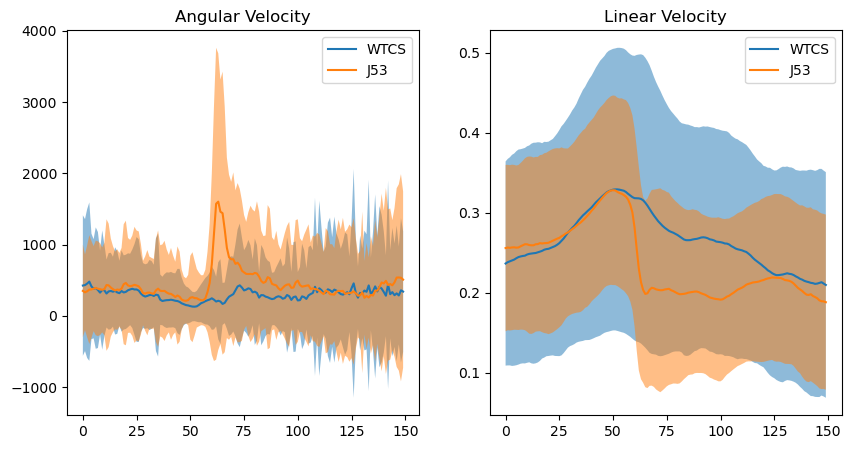

In [68]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

# plot angular velocity
plot_with_mean_and_std(wtcs_data["angular_velocity"], label="WTCS", ax=axs[0])
plot_with_mean_and_std(j53_data["angular_velocity"], label="J53", ax=axs[0])

# plot linear veloicty
plot_with_mean_and_std(wtcs_data["linear_velocity"], label="WTCS", ax=axs[1])
plot_with_mean_and_std(j53_data["linear_velocity"], label="J53", ax=axs[1])

axs[1].set_title("Linear Velocity")
axs[0].set_title("Angular Velocity")
plt.show()